## Set Env

In [ ]:
import os
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np 
import time
from datetime import datetime
import matplotlib.pyplot as plt


## User Configuration 

In [3]:

# select the dataset
#dataset='arcis3'
#dataset='cerra-land'
dataset='cerra-land6'
#dataset='mswep'

# regions
region_set='north'
#region_set='italy'

# if dataset is then
if dataset == 'arcis3':
    # unit: mm
    precip_dir='/work_big/users/zappa/ARCIS/daily'
    pr_name='rr'
    lat_name='lat'
    lon_name='lon'
    nc_files=["ARCIS3_GG_1961-2023_timestamped.nc"]
    sy='1961-01-01'
    ly='2023-12-31'  
elif dataset == 'mswep':
    # mm (need to pre-process from 3-hourly)
    precip_dir = '/work_big/users/zappa/MSWEP/Past/Daily/6UTC/'
    pr_name='precipitation'
    lat_name='lat'
    lon_name='lon'
    nc_files = sorted([file for file in os.listdir(precip_dir) if file.endswith('.nc')])
    sy='1980-01-01'
    ly='2019-12-31' 
elif dataset == 'cerra-land':
    # unit: kg/m2
    precip_dir = '/home/zappa/work_big/CERRA-LAND/daily/nc/regular'
    pr_name='tp'
    lat_name='lat'
    lon_name='lon'
    nc_files = sorted([file for file in os.listdir(precip_dir) if file.endswith('.nc')])
    sy='1984-08-01'
    ly='2021-04-30' 
elif dataset == 'cerra-land6':
    # unit: kg/m2
    precip_dir = '/home/zappa/work_big/CERRA-LAND/daily/nc/regular6'
    pr_name='tp'
    lat_name='lat'
    lon_name='lon'
    nc_files = sorted([file for file in os.listdir(precip_dir) if file.endswith('.nc')])
    sy='1984-08-01'
    ly='2021-04-30' 

# shape file intput of warning regions 
cwd = os.getcwd()
shapef_path = os.path.join(cwd,"ZA_2017_ID_v4_geowgs84.shp")

# processing method (dloop,loop,direct)
process_method='direct'

# reference climatology
start_time_clim = datetime(1985, 1, 1, 0, 0, 0)
end_time_clim = datetime(2019, 12, 31, 23, 0, 0)



## Read the shape files

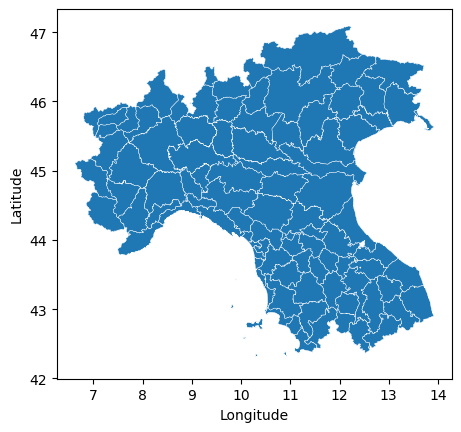

In [4]:

shape_gdf = gpd.read_file(shapef_path)

if region_set == 'north':
    arcis_regions=['Valle d\'Aosta','Piemonte','Liguria',
                   'Lombardia','Trentino Alto Adige','Veneto',
                   'Friuli Venezia Giulia','Emilia Romagna','Toscana',
                   'Umbria','Marche']
    shape_gdf = shape_gdf.loc[shape_gdf['Regione'].isin(arcis_regions)]


# create figure showing shapefiles
fig, ax = plt.subplots()
shape_gdf.plot(ax=ax,edgecolor='white', linewidth=0.3) 
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
fig.savefig(f"figures/map_warning_regions_{region_set}", dpi=300)

plt.show()


## Functions

In [13]:
def create_gdf_from_nc(nc_file,field_name,lat_name,lon_name):
    ds = xr.open_dataset(nc_file)
    df = ds[field_name].isel(time=0).to_dataframe()
    lats = df.index.get_level_values(lat_name)
    lons = df.index.get_level_values(lon_name)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs="EPSG:4326")
    gdf.reset_index(inplace=True)
    return gdf, lons, lats

def create_gdf_from_df(df,lat_name,lon_name):
    lats = df.index.get_level_values(lat_name)
    lons = df.index.get_level_values(lon_name)
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs="EPSG:4326")
    gdf.reset_index(inplace=True)
    return gdf

def create_gdf_from_ds(ds,lat_name,lon_name,gridtype):
    df = ds.to_dataframe()
    if gridtype == 'regular':
        lats = df.index.get_level_values(lat_name)
        lons = df.index.get_level_values(lon_name)
    elif gridtype == 'lambert':
        # Get the x and y variables
        x = dataset[lon_name].values
        y = dataset[lat_name].values

        # Get the Lambert Conformal parameters
        lcc_params = dataset['Lambert_Conformal']
        lon0 = lcc_params.longitude_of_central_meridian
        lat0 = lcc_params.latitude_of_projection_origin
        earth_radius = lcc_params.earth_radius
        false_easting = lcc_params.false_easting
        false_northing = lcc_params.false_northing
        standard_parallel = lcc_params.standard_parallel

        # Create a Lambert Conformal projection object
        lcc = pyproj.Proj(proj='lcc', lon_0=lon0, lat_0=lat0, lat_1=standard_parallel, lat_2=standard_parallel, a=earth_radius, x_0=false_easting, y_0=false_northing)

        # Create a meshgrid from x and y
        x_mesh, y_mesh = np.meshgrid(x, y)

        # Convert x and y to longitude and latitude
        lons, lats = lcc(x_mesh, y_mesh, inverse=True)
        lons=lons.flatten()
        lats=lats.flatten()

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(lons,lats),crs="EPSG:4326")
    print(gdf.head())
    gdf.reset_index(inplace=True)
    return gdf


def process_data1(precip_nc, pr_name, lat_name, lon_name, shape_gdf):
    # Your code here

    #[gdf,lons,lats]=create_gdf_from_nc(precip_nc, pr_name, lat_name, lon_name)
    ds = xr.open_dataset(precip_nc)
    
    results_data = {}

    for t in ds.time:
        print(t.values)
        ds1 = ds[pr_name].sel(time=t.values)
        df1 = ds1.to_dataframe()
        gdf1=create_gdf_from_df(df1,lat_name,lon_name)
        #gdf1 = gpd.GeoDataFrame(df1, geometry=gpd.points_from_xy(lons,lats),crs="EPSG:4326")
     
        region_data = {}
      
        for index, values in shape_gdf.iterrows():
            zone_shp = shape_gdf.loc[shape_gdf['row'] == values['row']]
            total_tp=gdf1.loc[gdf1['geometry'].within(zone_shp['geometry'].iloc[0]),pr_name].mean()

            #return total_tp
            region_data[values['Cod_DPC']] = total_tp

        results_data[t.values] = region_data

    results_df = pd.DataFrame(results_data).T
    results_df.columns=shape_gdf['Cod_DPC'].values
    results_df.index.name = 'Time'

    return results_df


def process_data2(precip_nc, pr_name, lat_name, lon_name, shape_gdf):
    # Ensure that shape_gdf has a unique index
    shape_gdf = shape_gdf.reset_index()

    ds = xr.open_dataset(precip_nc)
    results_data = {}

    for t in ds.time:
        print(t.values)
        ds1 = ds[pr_name].sel(time=t.values)
        df1 = ds1.to_dataframe()
        
        gdf1 = create_gdf_from_df(df1, lat_name, lon_name)

        # Perform a spatial join to associate each point with its region
        gdf1 = gpd.sjoin(gdf1, shape_gdf, predicate='within')

        # Group by region and sum the values
        region_data = gdf1.groupby('index_right')[pr_name].mean()

        # Convert the series to a dictionary and add it to results_data
        results_data[t.values] = region_data.to_dict()

    results_df = pd.DataFrame(results_data).T
    results_df.index.name = 'Time'
    results_df.columns=shape_gdf['Cod_DPC'].values

    return results_df


def process_data3(precip_nc, pr_name, lat_name, lon_name, shape_gdf):
    # Ensure that shape_gdf has a unique index
    shape_gdf = shape_gdf.reset_index()

    ds = xr.open_dataset(precip_nc).sel(time=slice(sy,ly))

    # Convert the entire Dataset to a DataFrame
    df = ds[pr_name].to_dataframe()
    gdf = create_gdf_from_df(df, lat_name, lon_name)

    # Perform a spatial join to associate each point with its region
    gdf = gpd.sjoin(gdf, shape_gdf, predicate='within')

    # Group by time and region, and sum the values
    results_data = gdf.groupby(['time', 'index_right'])[pr_name].mean()

    # Convert the series to a DataFrame and pivot it
    results_df = results_data.reset_index().pivot(index='time', columns='index_right', values=pr_name)

    # Rename the columns
    results_df.columns = shape_gdf.loc[results_df.columns, 'Cod_DPC'].values
    results_df.index.name = 'Time'
    #print(results_df)

    return results_df


def process_data(method,path,prname,latname,lonname,shape_gdf,sy,ly):
    if method == 'dloop':
        results = process_data1(path, prname, latname, lonname, shape_gdf)
    elif method == 'loop':
        results = process_data2(path, prname, latname, lonname, shape_gdf)
    elif method == 'direct':
        results = process_data3(path, prname, latname, lonname, shape_gdf)
    return results


## run the analysis

In [ ]:
precip_wr = pd.DataFrame()

counter=0
for pr_file in nc_files:
    # Process each .nc file here
    pr_file_path = os.path.join(precip_dir, pr_file)
    print(pr_file_path)

    # only time loop in process_data2
    st=time.time()
    tmp=process_data(process_method,pr_file_path, pr_name, lat_name, lon_name, shape_gdf,sy,ly)    
    precip_wr=pd.concat([precip_wr,tmp], ignore_index=False)
    et=time.time()
    print(f"{et-st}")

    # # Stop the loop
    # counter += 1
    # if counter == 2:
    #     break

precip_wr=precip_wr.round(3)

## Additional information

In [15]:

# select time period to compute climatological statistics
precip_wr_c = precip_wr[(precip_wr.index >= start_time_clim) & (precip_wr.index <= end_time_clim)]

# exclude drizzle/no rain days (1mm/day threshold)
precip_wr_cr = precip_wr_c[precip_wr_c > 1]

# compute threshold for intense events and index with information
qthreshold=0.99  
precip_threshold_row=pd.DataFrame(precip_wr_cr.quantile(qthreshold)).T
precip_threshold_row.index=[f'99p rainy days;{start_time_clim.year}-{end_time_clim.year}']
precip_wrt=pd.concat([precip_wr,precip_threshold_row], ignore_index=False)

# identify intense rainfall day
a=precip_wrt.values>precip_threshold_row.values

a2=np.any(a,axis=1) # at least one region
a3=np.sum(a,axis=1) # number of regions
precip_wrt['intense rain day']=a2
precip_wrt['#regions']=a3


In [16]:

# Initialize a new column to store the sum of 'area_kmq' for each row where 'a' is true
precip_wrt['sum_area_kmq'] = 0.0

# Get the column index for 'sum_area_kmq' once to avoid repeated lookups
sum_area_kmq_idx = precip_wrt.columns.get_loc('sum_area_kmq')

# Loop over the rows of 'a' and sum 'area_kmq' for each row where 'a' is true
for i in range(a.shape[0]):
    # Calculate the sum of 'area_kmq' for the current row where 'a' is true
    sum_area = shape_gdf.loc[a[i], 'area_kmq'].sum()
    
    # Assign the calculated sum to the corresponding row in 'precip_wrt'
    precip_wrt.iloc[i, sum_area_kmq_idx] = sum_area

# Identify intense rainfall days with area > 1000 km^2
precip_wrt['intense rain day (1000km2)'] = precip_wrt['sum_area_kmq'] > 1000.0
precip_wrt['intense rain day (2500km2)'] = precip_wrt['sum_area_kmq'] > 2500.0
precip_wrt['intense rain day (5000km2)'] = precip_wrt['sum_area_kmq'] > 5000.0

## Save output to excel file

In [17]:
# save output
dirout='/home/zappa/work_big/ENCIRCLE/precipitation_warning_regions'
fileout=f"{dirout}/{dataset}_{sy.replace('-','')}_{ly.replace('-','')}_{process_method}_{region_set}_withArea.xlsx"
print(fileout)
precip_wrt.to_excel(fileout, index=True)


## Display output to screen

In [18]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
print(precip_wrt)




                             VDAo-A    VDAo-B     VDAo-C     VDAo-D  \
1984-08-29 06:00:00        0.012000   1.11500   0.018000   0.006000   
1984-08-30 06:00:00        0.012000   1.17900   0.059000   0.001000   
1984-08-31 06:00:00        0.001000   0.29200   0.000000   0.005000   
1984-09-01 06:00:00        3.496000   1.69000   1.087000   3.978000   
1984-09-02 06:00:00        3.937000  10.75800   0.030000   8.073000   
...                             ...       ...        ...        ...   
2021-04-26 06:00:00        3.544000   5.29100  13.962000   7.420000   
2021-04-27 06:00:00        1.623000   1.68500   3.312000   6.377000   
2021-04-28 06:00:00       23.552000  15.35700  15.538000  28.600000   
2021-04-29 06:00:00       13.047000   5.11700  10.452000  14.339000   
99p rainy days;1985-2019  40.352871  55.31308  40.463879  39.456081   

                             Piem-A     Piem-B     Piem-C    Piem-D  \
1984-08-29 06:00:00        0.753000   2.651000   3.114000   0.54400   
1984-